# Check MWDC position resolutions
Input parquet file should be the output of `mwdc_processor.py` output without --output-wire-data option. <br>
All the shifts parameters needs to be adjusted before checking this notebook.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

df = spark.read.parquet("parquet/run1008_mwdc.parquet")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 03:16:21 WARN Utils: Your hostname, gpuana02, resolves to a loopback address: 127.0.1.1; using 192.168.1.216 instead (on interface enp4s0)
26/01/15 03:16:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/15 03:16:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/15 03:16:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/15 03:16:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/15 03:16:22 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+---------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+------------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+----------+-----------+---------------+---------------+-----------+-----------+---------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------------------+-------------------+------------------+-------------------+-------+
|hbfNumber|dc31_x1_dl|dc31_x1_id0|dc31_x1_charge0|dc31_x1_timing0|dc31_x2_dl|dc3

## Plot x-y images for each plane

[('dc31_x1_posi', 'dc31_y1_posi'), ('dc31_x2_posi', 'dc31_y2_posi'), ('dc31_x3_posi', 'dc31_y3_posi'), ('dc31_x4_posi', 'dc31_y4_posi'), ('dc32_x1_posi', 'dc32_y1_posi'), ('dc32_x2_posi', 'dc32_y2_posi')]
Statistics:
[[    0.     0.     0.]
 [    0. 59411.     0.]
 [    0.     0.     0.]]
Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [1.0000e+00 5.9421e+04 0.0000e+00]
 [0.0000e+00 2.0000e+00 0.0000e+00]]
Statistics:
[[    0.     0.     0.]
 [    0. 59417.     0.]
 [    0.     0.     0.]]
Statistics:
[[0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 5.9445e+04 0.0000e+00]
 [0.0000e+00 1.0000e+00 0.0000e+00]]
Statistics:
[[0.0000e+00 3.0000e+00 0.0000e+00]
 [0.0000e+00 5.9116e+04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]
Statistics:
[[    0.     0.     0.]
 [    0. 58717.     0.]
 [    0.     0.     0.]]


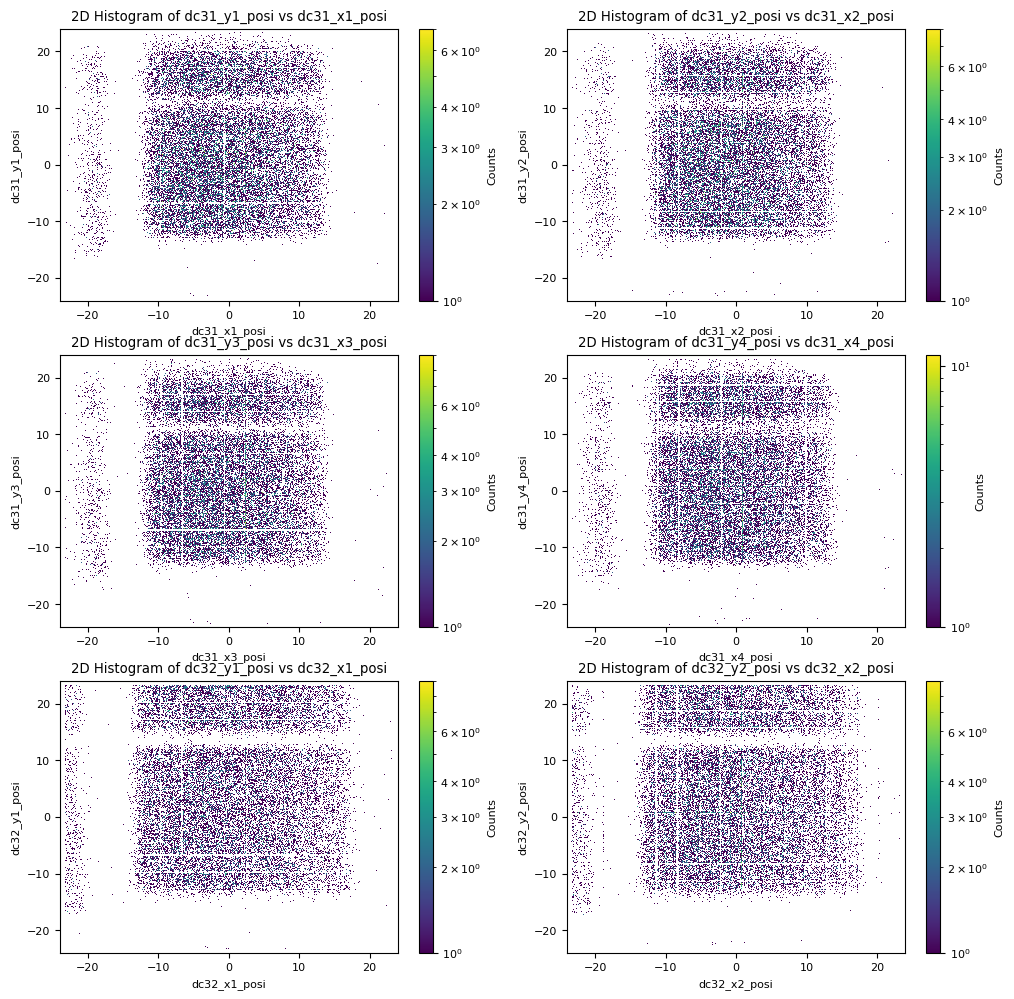

In [2]:
from matplotlib import pyplot as plt
from hist.sparkHist2d import Hist2D
from matplotlib.colors import LogNorm


planes = [(f"dc31_x{x}_posi", f"dc31_y{x}_posi") for x in range(1,5)]
planes = planes + [(f"dc32_x{x}_posi", f"dc32_y{x}_posi") for x in range(1,3)]
print(planes)
plt.figure(0, figsize=(12,12))
plt.rcParams["font.size"] = 8
for i, plane in enumerate(planes):
    q, mod = divmod(i,2)
    plt.subplot2grid((3,2),(q,mod))
    d = Hist2D(df, [plane[0],plane[1]],[500,500],[[-24,24],[-24,24]],  interpolation='none', norm=LogNorm())
plt.show()

## DC31 position resolution
= errors on `dc31_x_posi` and `dc31_y_posi` in sigma

Number of events: 59710
Total entries: 59297, Underflow: 39, Inside: 59216, Overflow: 42
Total entries: 59302, Underflow: 44, Inside: 59221, Overflow: 37
Total entries: 59290, Underflow: 32, Inside: 59217, Overflow: 41
Total entries: 59300, Underflow: 42, Inside: 59231, Overflow: 27


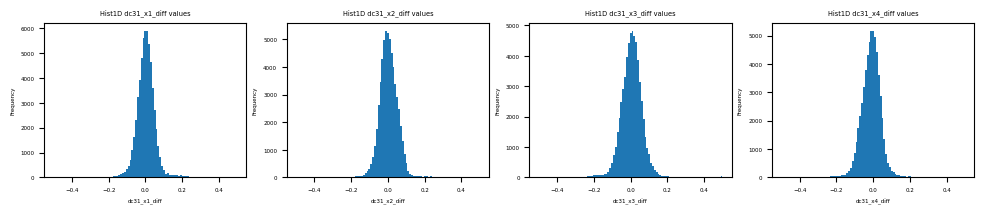

[0.054535719638482215, 0.05644684718312265, 0.06110472779021408, 0.05859770906237415]
DC31 x-plane resolution: 25.0 um
Total entries: 59184, Underflow: 39, Inside: 59120, Overflow: 25
Total entries: 59164, Underflow: 19, Inside: 59116, Overflow: 29
Total entries: 59184, Underflow: 39, Inside: 59118, Overflow: 27
Total entries: 59169, Underflow: 24, Inside: 59118, Overflow: 27


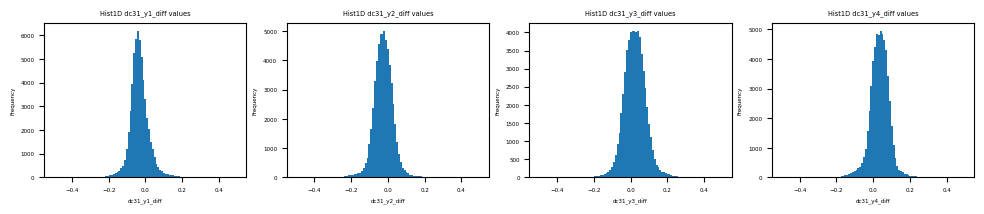

[0.06483989879346289, 0.06164508103364817, 0.06777406117524087, 0.06564815643661714]
DC31 y-plane resolution: 28.2 um


In [3]:
import math

from hist.sparkHist1d import Hist1D
planes = ["x", "y"]

n = df.count()
print(f"Number of events: {n}")
for plane in planes:
    dc31_planes = [f"dc31_{plane}{x}" for x in range(1,5)]

    df_avg = df.withColumn(f"dc31_{plane}_avg", sum(F.col(x+"_posi") for x in dc31_planes)/len(dc31_planes))
    stdevs = []
    plt.figure(0, figsize=(12,2))
    plt.rcParams["font.size"] = 4
    for i, pl in enumerate(dc31_planes):
        df_std = df_avg.withColumn(f"{pl}_diff", F.col(f"{pl}_posi") - F.col(f"dc31_{plane}_avg"))
        plt.subplot2grid((1,4),(0,i))
        h = Hist1D(df_std, f"{pl}_diff", 100, [-0.5, 0.5])
        df_std = df_std.filter(f"ABS({pl}_diff) < 0.8")
        df_std = df_std.withColumn(f"{pl}_resol", F.col(f"{pl}_diff")*F.col(f"{pl}_diff"))
        stdevs.append(df_std.select(F.sum(f"{pl}_resol")).collect()[0][0]/n)
    plt.show()
    print([math.sqrt(x) for x in stdevs])
    npl = float(len(stdevs))
    rms = math.sqrt(sum(stdevs)/npl*(npl-1))/npl
    print(f"DC31 {plane}-plane resolution: {rms*1000:.1f} um")


## DC32 Position Resolution
= errors on `dc32_x_posi` and `dc32_y_posi` in sigma

Number of events: 59710
Total entries: 60746, Underflow: 1621, Inside: 59107, Overflow: 18
Total entries: 59143, Underflow: 18, Inside: 57504, Overflow: 1621


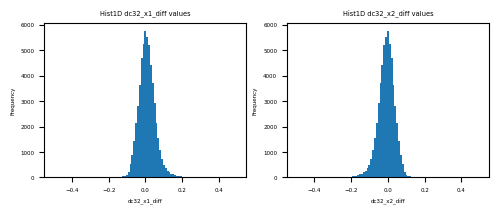

[0.05497672639463192, 0.05497672639463192]
DC32 x-plane resolution: 27.5 um
Total entries: 58735, Underflow: 28, Inside: 58698, Overflow: 9
Total entries: 58716, Underflow: 9, Inside: 58679, Overflow: 28


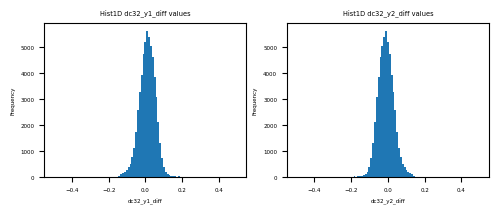

[0.05566438313971732, 0.05566438313971732]
DC32 y-plane resolution: 27.8 um


In [4]:
planes = ["x", "y"]

n = df.count()
print(f"Number of events: {n}")
for plane in planes:
    dc32_planes = [f"dc32_{plane}{x}" for x in range(1,3)]

    df_avg = df.withColumn(f"dc32_{plane}_avg", sum(F.col(x+"_posi") for x in dc32_planes)/len(dc32_planes))
    stdevs = []
    plt.figure(0, figsize=(12,2))
    plt.rcParams["font.size"] = 4
    for i, pl in enumerate(dc32_planes):
        df_std = df_avg.withColumn(f"{pl}_diff", F.col(f"{pl}_posi") - F.col(f"dc32_{plane}_avg"))
        plt.subplot2grid((1,4),(0,i))
        h = Hist1D(df_std, f"{pl}_diff", 100, [-0.5, 0.5])
        df_std = df_std.filter(f"ABS({pl}_diff) < 0.8")
        df_std = df_std.withColumn(f"{pl}_resol", F.col(f"{pl}_diff")*F.col(f"{pl}_diff"))
        stdevs.append(df_std.select(F.sum(f"{pl}_resol")).collect()[0][0]/n)
    plt.show()
    print([math.sqrt(x) for x in stdevs])
    npl = len(stdevs)
    rms = math.sqrt(sum(stdevs)/npl*(npl-1))/npl
    print(f"DC32 {plane}-plane resolution: {rms*1000:.1f} um")